## Séries Temporais | Exercício 4 - Vendas de Produtos

**4. Series de tiempo**

**Fonte: series.csv**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy
import numpy as np
import seaborn as sns
from datetime import timedelta

#Aumento de gradiente com a técnica XGBoost para modelagem de séries temporais
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error

C:\Users\emanoelle\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df_vendas = pd.read_csv("data/series.csv")

In [3]:
df_vendas.sample(5)

,CATEGORY,DATE,UNITS_SOLD
528,CATEG-2,2021-06-06,42
1452,CATEG-1,2020-06-08,58
836,CATEG-2,2020-07-08,75
1465,CATEG-1,2021-10-05,38
716,CATEG-2,2019-08-10,8


In [4]:
df_vendas.shape

(2686, 3)

#### Pré-Processamento dos dados

In [5]:
#Conversão de data para datetime e index do df
df_vendas['DATE'] = pd.to_datetime(df_vendas['DATE'])
df_vendas = df_vendas.set_index('DATE')

In [6]:
df_vendas.describe()

,UNITS_SOLD
count,2686.000000
mean,531.340283
std,840.944458
min,0.000000
25%,25.000000
50%,62.000000
75%,695.000000
max,7551.000000


In [7]:
#Seleção de linhas específicas
df_vendas_sold = df_vendas[['UNITS_SOLD']]

In [8]:
df_vendas_sold

,UNITS_SOLD
DATE,
2021-08-17,59
2020-09-19,40
2021-10-26,23
2021-04-27,60
2021-05-05,61
...,...
2021-02-18,78
2020-12-05,8
2020-02-05,3


In [9]:
df_vendas_sold.index

DatetimeIndex(['2021-08-17', '2020-09-19', '2021-10-26', '2021-04-27',
               '2021-05-05', '2018-10-18', '2021-06-26', '2020-08-23',
               '2020-03-28', '2020-06-11',
               ...
               '2019-07-16', '2020-03-06', '2021-01-21', '2020-08-30',
               '2020-11-28', '2021-02-18', '2020-12-05', '2020-02-05',
               '2020-06-05', '2021-09-03'],
              dtype='datetime64[ns]', name='DATE', length=2686, freq=None)

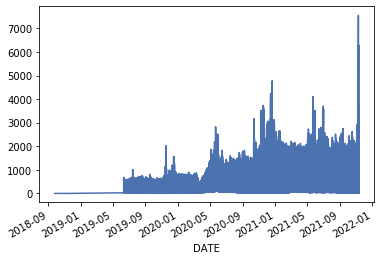

In [10]:
df_vendas_sold['UNITS_SOLD'].plot(color='#4C72B0')

#### Tratamento dos dados

In [11]:
#Verificação de missings
df_vendas_sold.isnull().sum()

UNITS_SOLD    0
dtype: int64

In [12]:
# Verificando dados sujos
sujos = df_vendas_sold['UNITS_SOLD'] == 0
sujos.sum()

14

In [13]:
# Filtrando dados sujos
df_vendas_sold[sujos] # apenas dados sujos
df_vendas_sold[~sujos] # apenas dados não-sujos
df_vendas_sold = df_vendas_sold[~sujos] # mudando o dataframe

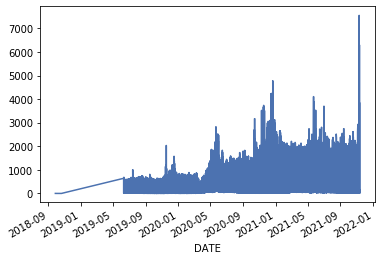

In [14]:
df_vendas_sold['UNITS_SOLD'].plot(color='#4C72B0')

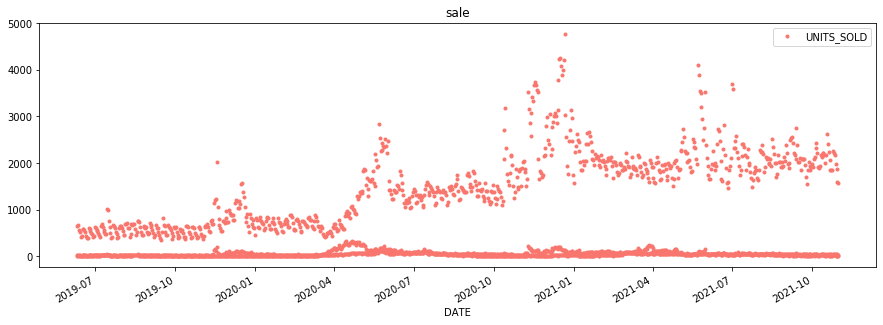

In [30]:
#Densidade principal de unidades vendidas na faixa entre 500 à 1000 e 1000 à 2000
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = df_vendas_sold.plot(style='.', figsize=(15,5), color=color_pal[0], title='sale')

In [15]:
#Selecão de intervalo temporal
df_vendas_sold = df_vendas_sold['2019-06':'2021-10']

C:\Users\emanoelle\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  


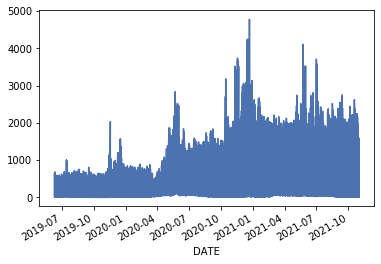

In [16]:
df_vendas_sold['UNITS_SOLD'].plot(color='#4C72B0')

In [17]:
#Divisão dos dados
split_date = '2021-10-05'
data_train = df_vendas_sold.loc[df_vendas_sold.index <= split_date].copy()
data_test = df_vendas_sold.loc[df_vendas_sold.index > split_date].copy()

**Divisão dos dados em treinamento e teste após a data 05-10-2021. Para verificar o modelo após 21 dias de previsão**

In [18]:
data_train

,UNITS_SOLD
DATE,
2021-08-17,59
2020-09-19,40
2021-04-27,60
2021-05-05,61
2021-06-26,1462
...,...
2021-02-18,78
2020-12-05,8
2020-02-05,3


In [19]:
data_test

,UNITS_SOLD
DATE,
2021-10-26,23
2021-10-12,2128
2021-10-09,1888
2021-10-09,37
2021-10-20,14
...,...
2021-10-18,20
2021-10-07,43
2021-10-19,2398


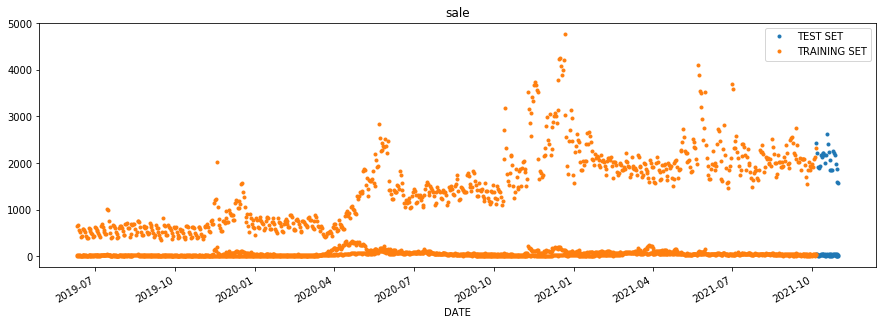

In [20]:
#Visualização dos dados divididos
_ = data_test \
    .rename(columns={'UNITS_SOLD': 'TEST SET'}) \
    .join(data_train.rename(columns={'UNITS_SOLD': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='sale', style='.')

In [21]:
#Função de variações da data
def create_features(df_vendas_sold, label=None):
    df_vendas_sold['date'] = df_vendas_sold.index
    df_vendas_sold['hour'] = df_vendas_sold['date'].dt.hour
    df_vendas_sold['dayofweek'] = df_vendas_sold['date'].dt.dayofweek
    df_vendas_sold['quarter'] = df_vendas_sold['date'].dt.quarter
    df_vendas_sold['month'] = df_vendas_sold['date'].dt.month
    df_vendas_sold['year'] = df_vendas_sold['date'].dt.year
    df_vendas_sold['dayofyear'] = df_vendas_sold['date'].dt.dayofyear
    df_vendas_sold['dayofmonth'] = df_vendas_sold['date'].dt.day
    df_vendas_sold['weekofyear'] = df_vendas_sold['date'].dt.weekofyear
    
    X = df_vendas_sold[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df_vendas_sold[label]
        return X, y
    return X

In [22]:
#Aplicação da função nos dados
X_train, y_train = create_features(data_train, label='UNITS_SOLD')
X_test, y_test = create_features(data_test, label='UNITS_SOLD')
X_train

C:\Users\emanoelle\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  # Remove the CWD from sys.path while we load stuff.


,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
DATE,,,,,,,,
2021-08-17,0,1,3,8,2021,229,17,33
2020-09-19,0,5,3,9,2020,263,19,38
2021-04-27,0,1,2,4,2021,117,27,17
2021-05-05,0,2,2,5,2021,125,5,18
2021-06-26,0,5,2,6,2021,177,26,25
...,...,...,...,...,...,...,...,...
2021-02-18,0,3,1,2,2021,49,18,7
2020-12-05,0,5,4,12,2020,340,5,49
2020-02-05,0,2,1,2,2020,36,5,6


In [24]:
#Instanciando o modelo
reg = xgb.XGBRegressor(n_estimators=1000)

In [25]:
#Ajuste de dados ao modelo
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False)

C:\Users\emanoelle\Anaconda3\lib\site-packages\xgboost\sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

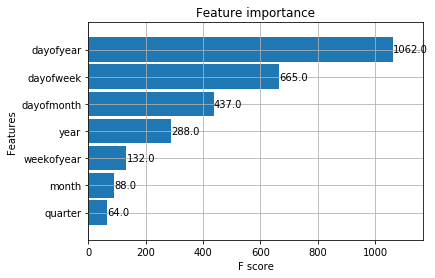

In [26]:
#Técnica de importância do recurso - Recurso dos dados em que o modelo mais depende para fazer a previsão
_ = plot_importance(reg, height=0.9)

 **Dia do ano é o recurso mais importante e o modelo o usou mais comumente para dividir em mais nós**

In [27]:
#Previsão do modelo
data_test['number_Prediction'] = reg.predict(X_test)
data_all = pd.concat([data_test, data_train], sort=False)

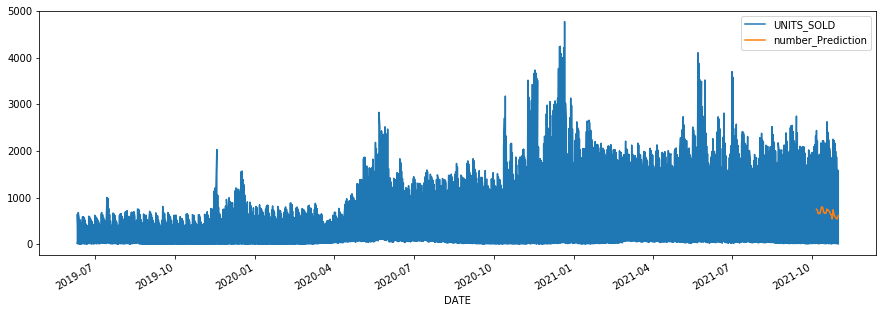

In [28]:
#Visualização da previsão
_ = data_all[['UNITS_SOLD','number_Prediction']].plot(figsize=(15, 5))

**Os valores de ordem estão se movendo em torno do intervalo entre 500 à 1000 e o modelo também está prevendo entre esse intervalo em 21 dias**